In [1]:
import pandas as pd
import numpy as np
import plotly.express as px

In [34]:
df = pd.read_gbq('''SELECT * FROM clima.precipitacion_mensual_regional''', project_id='cr2tech', use_bqstorage_api=True)
df.sort_values(by='date', inplace=True)
df['month'] = df.date.dt.month
df.reset_index(drop=True, inplace=True)
df.head(2)

,date,Coquimbo,Valparaiso,Metropolitana_de_Santiago,Libertador_Gral__Bernardo_O_Higgins,Maule,Biobio,La_Araucania,Los_Rios,month
0,1979-01-01,2.641948,0.587062,2.447114,1.608992,3.736215,17.859634,25.212940,45.596447,1
1,1979-02-01,1.179804,2.432192,3.997852,4.346310,16.347637,17.680612,18.085072,34.075039,2


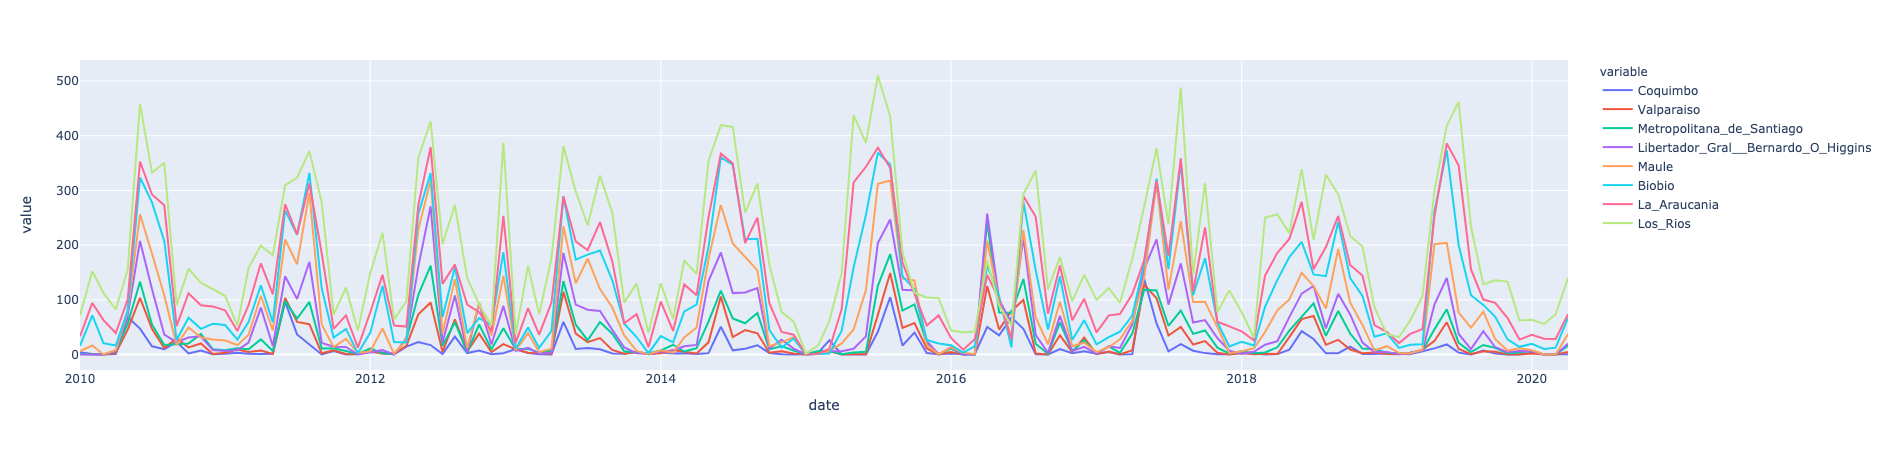

In [35]:
regiones = ['Coquimbo', 'Valparaiso', 'Metropolitana_de_Santiago', 'Libertador_Gral__Bernardo_O_Higgins', 'Maule', 'Biobio', 'La_Araucania', 'Los_Rios']

df_toplot = df.query('date>="2010-01-01"').melt(id_vars='date', value_vars=['Coquimbo', 'Valparaiso', 'Metropolitana_de_Santiago',
       'Libertador_Gral__Bernardo_O_Higgins', 'Maule', 'Biobio',
       'La_Araucania', 'Los_Rios'])

fig = px.line(df_toplot, x='date', y='value', color='variable')
fig.show()

In [31]:
# suavizamos la señal con un moving average de 3 meses
# luego calculamos media y desviación estándar por mes hacia el pasado
n_meses_ma = 3
for region in regiones:
    df[f'{region}_suave'] = df[['date',region]].rolling(window=n_meses_ma, min_periods=1).mean().reset_index()[region]#.Los_Rios#.reset_index()

    df[f'mean_{region}'] = df[['date',f'{region}_suave', 'month']].groupby('month')[f'{region}_suave'].transform(lambda x: x.expanding().mean()).reset_index().shift(12)[f'{region}_suave']
    df[f'std_{region}'] = df[['date',f'{region}_suave', 'month']].groupby('month')[f'{region}_suave'].transform(lambda x: x.expanding().std()).reset_index().shift(12)[f'{region}_suave']
    df[f'z_score_{region}'] = df.eval(f'({region}_suave - mean_{region})/std_{region}')

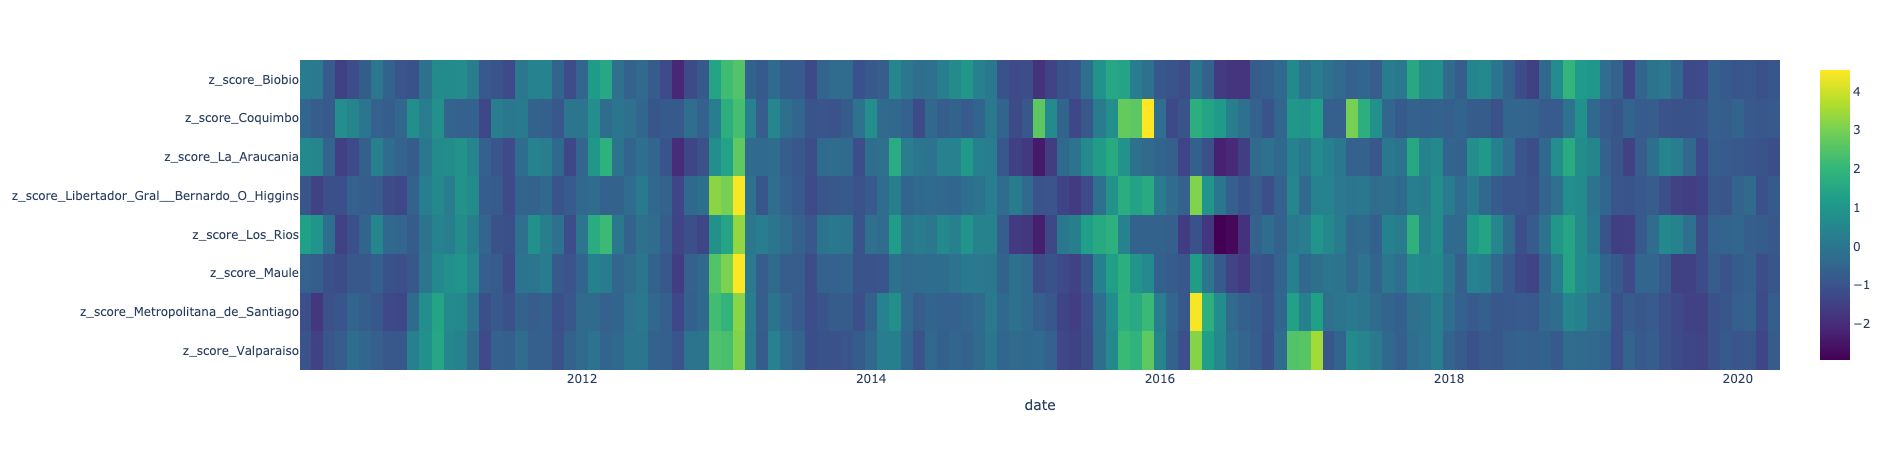

In [33]:
import plotly.express as px
df_pivoted = df.query('date>"2010-01-01"').pivot_table(values=[m for m in df.columns if 'z_score' in m], index='date').T.copy()
fig = px.imshow(df_pivoted, color_continuous_scale='Viridis')
fig.show()